<a href="https://colab.research.google.com/github/indhu68/Intro_to_DL_Project/blob/main/GIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch-geometric

In [2]:
!pip install community

In [3]:
!pip install networkx

In [4]:
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader, Data
from torch_geometric.nn import GINConv, Sequential
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [5]:
# Load and preprocess data
data = pd.read_csv('https://raw.githubusercontent.com/indhu68/Intro_to_DL_Project/main/Kasungu_Telemetry_Pts_Oct23.csv', parse_dates=['Time.Stamp'])
data = data[["Index","Tag", "Latitude", "Longitude", "Time.Stamp"]]
data['Time.Stamp'] = pd.to_datetime(data['Time.Stamp'])
data.sort_values(by=['Tag', 'Time.Stamp'], inplace=True)

In [6]:
data['Time_diff'] = data.groupby('Tag')['Time.Stamp'].diff().dt.total_seconds().fillna(0)
data['Lat_diff'] = data.groupby('Tag')['Latitude'].diff().fillna(0)
data['Lon_diff'] = data.groupby('Tag')['Longitude'].diff().fillna(0)
data['Speed'] = np.sqrt(data['Lat_diff']**2 + data['Lon_diff']**2) / (data['Time_diff'] + 1e-5)
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(data.mean(), inplace=True)

In [7]:
scaler = MinMaxScaler()
features = scaler.fit_transform(data[['Latitude', 'Longitude', 'Speed']])
edges = []
for tag in data['Tag'].unique():
    indices = data.index[data['Tag'] == tag].tolist()
    for i in range(len(indices) - 1):
        edges.append([indices[i], indices[i + 1]])

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(data[['Latitude', 'Longitude']].values, dtype=torch.float)


In [8]:
# Graph data object
graph_data = Data(x=x, edge_index=edge_index, y=y)
num_nodes = x.size(0)
train_indices, val_indices = train_test_split(np.arange(num_nodes), test_size=0.2, random_state=42)
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_indices] = True
val_mask[val_indices] = True
graph_data.train_mask = train_mask
graph_data.val_mask = val_mask

train_loader = DataLoader([graph_data], batch_size=32, shuffle=True)
val_loader = DataLoader([graph_data], batch_size=32, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [9]:
# Define the GIN model
class GIN(torch.nn.Module):
    def __init__(self, num_features, hidden_dim, output_dim):
        super(GIN, self).__init__()
        self.gin = Sequential('x, edge_index', [
            (GINConv(torch.nn.Linear(num_features, hidden_dim), train_eps=True), 'x, edge_index -> x'),
            torch.nn.ReLU(inplace=True),
            (GINConv(torch.nn.Linear(hidden_dim, hidden_dim), train_eps=True), 'x, edge_index -> x'),
            torch.nn.ReLU(inplace=True)
        ])
        self.regressor = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gin(x, edge_index)
        x = self.regressor(x)
        return x

model = GIN(num_features=3, hidden_dim=128, output_dim=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss(reduction='mean')

Epoch 1: Train Loss: 654.7513, Val Loss: 570.9230, Train RMSE: 25.5881, Val RMSE: 23.8940
Epoch 2: Train Loss: 570.9333, Val Loss: 495.6382, Train RMSE: 23.8942, Val RMSE: 22.2629
Epoch 3: Train Loss: 495.6544, Val Loss: 402.2341, Train RMSE: 22.2633, Val RMSE: 20.0558
Epoch 4: Train Loss: 402.2567, Val Loss: 292.0549, Train RMSE: 20.0563, Val RMSE: 17.0896
Epoch 5: Train Loss: 292.0830, Val Loss: 176.1930, Train RMSE: 17.0904, Val RMSE: 13.2738
Epoch 6: Train Loss: 176.2223, Val Loss: 76.1086, Train RMSE: 13.2749, Val RMSE: 8.7240
Epoch 7: Train Loss: 76.1314, Val Loss: 26.4135, Train RMSE: 8.7253, Val RMSE: 5.1394
Epoch 8: Train Loss: 26.4192, Val Loss: 48.7517, Train RMSE: 5.1400, Val RMSE: 6.9822
Epoch 9: Train Loss: 48.7315, Val Loss: 100.2454, Train RMSE: 6.9808, Val RMSE: 10.0123
Epoch 10: Train Loss: 100.2031, Val Loss: 113.5563, Train RMSE: 10.0101, Val RMSE: 10.6563
Epoch 11: Train Loss: 113.5078, Val Loss: 84.1315, Train RMSE: 10.6540, Val RMSE: 9.1723
Epoch 12: Train Loss: 

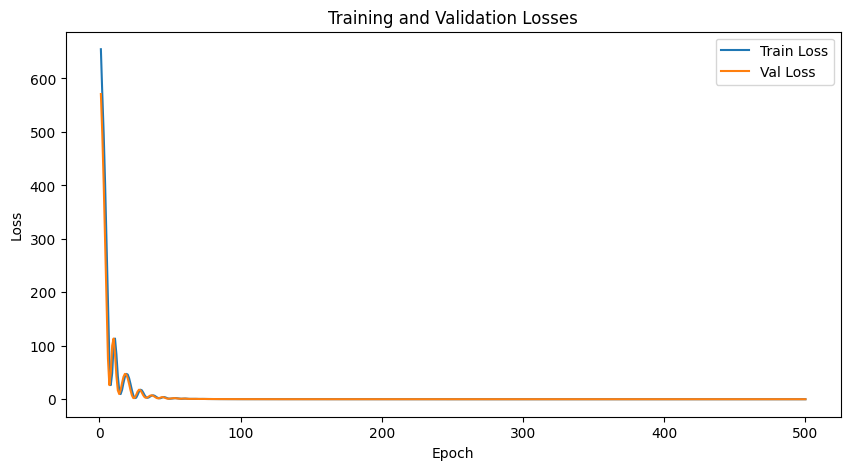

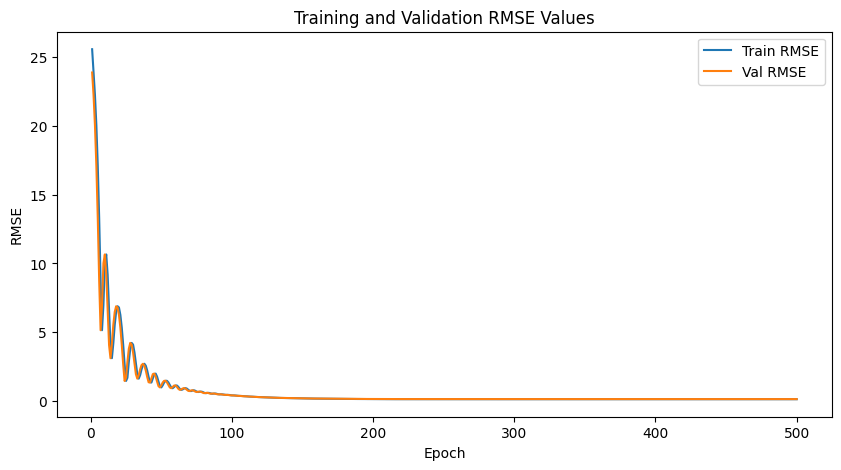

In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, epochs):
    train_losses = []
    val_losses = []
    train_rmse_values = []
    val_rmse_values = []

    for epoch in range(1, epochs + 1):
        model.train()
        total_train_loss = 0
        total_train_rmse = 0

        for data in train_loader:
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item() * data.num_graphs

            # Calculate RMSE
            rmse = torch.sqrt(nn.functional.mse_loss(output[data.train_mask], data.y[data.train_mask]))
            total_train_rmse += rmse.item() * data.num_graphs

        model.eval()
        total_val_loss = 0
        total_val_rmse = 0

        with torch.no_grad():
            for data in val_loader:
                output = model(data)
                loss = criterion(output[data.val_mask], data.y[data.val_mask])
                total_val_loss += loss.item() * data.num_graphs

                # Calculate RMSE
                rmse = torch.sqrt(nn.functional.mse_loss(output[data.val_mask], data.y[data.val_mask]))
                total_val_rmse += rmse.item() * data.num_graphs

        # Average losses and RMSE over all batches
        avg_train_loss = total_train_loss / len(train_loader.dataset)
        avg_val_loss = total_val_loss / len(val_loader.dataset)
        avg_train_rmse = total_train_rmse / len(train_loader.dataset)
        avg_val_rmse = total_val_rmse / len(val_loader.dataset)

        # Record losses and RMSE values
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_rmse_values.append(avg_train_rmse)
        val_rmse_values.append(avg_val_rmse)

        print(f'Epoch {epoch}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train RMSE: {avg_train_rmse:.4f}, Val RMSE: {avg_val_rmse:.4f}')

    # Plotting training and validation losses
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.show()

    # Plotting training and validation RMSE values
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_rmse_values, label='Train RMSE')
    plt.plot(range(1, epochs + 1), val_rmse_values, label='Val RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.title('Training and Validation RMSE Values')
    plt.legend()
    plt.show()

# Train and validate the model
train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, 500)


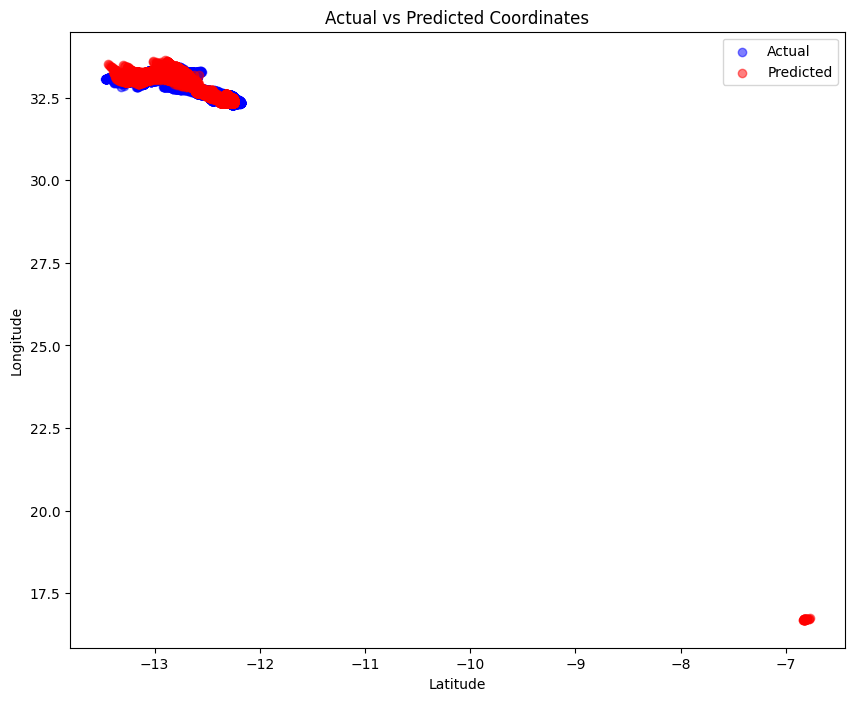

Average Evaluation Loss: 0.0147
Root Mean Square Error (RMSE): 0.1210


In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Save the model
torch.save(model.state_dict(), 'gin_model.pt')

# Load and evaluate the model
model.load_state_dict(torch.load('gin_model.pt'))
model.eval()

def evaluate_model(test_loader, model):
    actuals = []
    predictions = []
    total_loss = 0
    criterion = torch.nn.MSELoss()  # Assuming MSE loss for evaluation
    with torch.no_grad():
        for data in test_loader:
            output = model(data)
            loss = criterion(output, data.y)
            total_loss += loss.item()
            actuals.append(data.y.cpu().numpy())
            predictions.append(output.cpu().numpy())

    actuals = np.vstack(actuals)
    predictions = np.vstack(predictions)
    avg_loss = total_loss / len(test_loader)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    return actuals, predictions, avg_loss, rmse

def visualize_results(test_loader, model):
    actuals, predictions, avg_loss, rmse = evaluate_model(test_loader, model)



    plt.figure(figsize=(10, 8))
    plt.scatter(actuals[:, 0], actuals[:, 1], color='blue', label='Actual', alpha=0.5)
    plt.scatter(predictions[:, 0], predictions[:, 1], color='red', label='Predicted', alpha=0.5)
    plt.title('Actual vs Predicted Coordinates')
    plt.xlabel('Latitude')
    plt.ylabel('Longitude')
    plt.legend()
    plt.show()

    print(f"Average Evaluation Loss: {avg_loss:.4f}")
    print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

visualize_results(val_loader, model)


In [16]:
!pip install matplotlib networkx python-louvain


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import community as community_louvain

def plot_graph(G, pos, title='Graph Visualization'):
    plt.figure(figsize=(8, 8))
    plt.title(title)
    nx.draw(G, pos, node_size=70, node_color='blue', edge_color='gray')
    plt.show()

def plot_communities(G, pos):
    partition = community_louvain.best_partition(G)
    cmap = plt.get_cmap('viridis')
    plt.figure(figsize=(8, 8))
    plt.title('Community Structure')
    nx.draw_networkx_nodes(G, pos, node_size=70, cmap=cmap, node_color=list(partition.values()))
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.show()

def plot_centrality(G, pos):
    centrality = nx.degree_centrality(G)
    node_size = [v * 800 for v in centrality.values()]
    cmap = plt.get_cmap('plasma')
    plt.figure(figsize=(8, 8))
    plt.title('Node Centrality')
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=list(centrality.values()), cmap=cmap)
    nx.draw_networkx_edges(G, pos, alpha=0.5)
    plt.show()

# Create a NetworkX graph from the edge index used in your GNN
edge_index_np = graph_data.edge_index.numpy()
G = nx.Graph()
G.add_edges_from(edge_index_np.transpose())

# Calculate position once
pos = nx.spring_layout(G, scale=1)  # Adjust 'scale' as necessary

# Use the visualization functions after model evaluation
plot_graph(G, pos, 'Graph Structure Post-Evaluation')
plot_communities(G, pos)
plot_centrality(G, pos)
